# Inference Test Mosaic

### Load dependencies

In [1]:
import torch, os, cv2
import run
import numpy as np
import pandas as pd
import util.misc as misc
import torchvision.transforms.functional as TF
from PIL import Image
import torch.nn.functional as F

/home/matteopierucci/anaconda3/envs/clipcount/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Load inference model

In [3]:
SCALE_FACTOR = 60
model_ckpt = './ckpt/clipcount_pretrained.ckpt' # pre-trained model
model = run.Model.load_from_checkpoint(model_ckpt, strict=False)
model.eval()

Model(
  (model): CLIPCount(
    (clip): CLIP(
      (visual): VisionTransformer(
        (conv1): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16), bias=False)
        (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (transformer): Transformer(
          (resblocks): Sequential(
            (0): ResidualAttentionBlock(
              (attn): MultiheadAttention(
                (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
              )
              (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
              (mlp): Sequential(
                (c_fc): Linear(in_features=768, out_features=3072, bias=True)
                (gelu): QuickGELU()
                (c_proj): Linear(in_features=3072, out_features=768, bias=True)
              )
              (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
            )
            (1): ResidualAttentionBlock(
              (attn): MultiheadAttent

In [4]:
def infer(img, prompt):
    model.eval()
    model.model = model.model.cuda()
    with torch.no_grad():
        # reshape height to 384, keep aspect ratio
        img = torch.from_numpy(img).permute(2, 0, 1).unsqueeze(0).cuda()
        img = TF.resize(img, (384))
        
        img = img.float()/255.
        img = torch.clamp(img, 0, 1)
        prompt = [prompt]
        
        with torch.cuda.amp.autocast():
            raw_h, raw_w = img.shape[2:]
            patches, _ = misc.sliding_window(img,stride=128)
            #covert to batch
            patches = torch.from_numpy(patches).float().to(img.device)
            prompt = np.repeat(prompt, patches.shape[0], axis=0)
            output = model.forward(patches, prompt)
            output.unsqueeze_(1)
            output = misc.window_composite(output, stride=128)
            output = output.squeeze(1)
            #crop to original width
            output = output[:, :, :raw_w]
        
        pred_cnt = torch.sum(output[0]/SCALE_FACTOR).item()
        pred_density = output[0].detach().cpu().numpy()
        # normalize
        pred_density = pred_density/pred_density.max()
        pred_density_write = 1. - pred_density
        pred_density_write = cv2.applyColorMap(np.uint8(255*pred_density_write), cv2.COLORMAP_JET)
        pred_density_write = pred_density_write/255.
        # pred_rgb = cv2.applyColorMap(np.uint8(255*pred_density), cv2.COLORMAP_JET)
        img = img.squeeze(0).permute(1, 2, 0).detach().cpu().numpy()

        
        heatmap_pred = 0.33 * img + 0.67 * pred_density_write
        heatmap_pred = heatmap_pred/heatmap_pred.max()
    return heatmap_pred, pred_cnt, pred_density

### Replicate paper results

In [5]:
import os, json
import pandas as pd
import tqdm
import matplotlib.pyplot as plt

In [6]:
img_directory = './data/FSC/images_384_VarV2'

data_dir = "./data/FSC/FSC_147"
split_classes_file = "Split_Classes_FSC147.json"
split_images_file = "Train_Test_Val_FSC_147.json"
gt_json_filename = "gt_cnts_FSC147.json"

img_class_txt = "ImageClasses_FSC147.txt"
            
with open(os.path.join(data_dir, split_classes_file), 'r') as f:
    split_classes = json.load(f)

with open(os.path.join(data_dir, split_images_file), 'r') as f:
    split_images = json.load(f)    

# importing GT Counts JSON
with open(os.path.join(data_dir, gt_json_filename), 'r') as file:
    gt_counts_dict = json.load(file)
    
img_classes = {}

with open(os.path.join(data_dir, img_class_txt), 'r') as file:
    for line in file:
        line = line.strip().split('\t')
        if len(line) == 2:
            img_name, label = line
            img_classes[img_name] = label

    
df = pd.DataFrame([], columns=split_classes["test"], index=split_images["test"])

In [7]:
cnt_errors = 0
squared_errors = []

for img_filename in tqdm.tqdm(split_images["test"]):
    
    img = Image.open(os.path.join(img_directory, img_filename))
    img.load()
    img_array = np.array(img)
    
    prompt = img_classes[img_filename]
    _, pred_cnt, _ = infer(img_array, prompt)
    
    cnt_error = abs(pred_cnt - gt_counts_dict[img_filename])
    cnt_errors += cnt_error
    squared_error = cnt_error ** 2
    squared_errors.append(squared_error)

mae = cnt_errors/len(split_images["test"])
mse = np.mean(squared_errors)
rmse = np.sqrt(mse)

print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)

100%|██████████| 1190/1190 [20:10<00:00,  1.02s/it]

Mean Absolute Error (MAE): 17.364147846638655
Mean Squared Error (MSE): 11074.35139873088
Root Mean Squared Error (RMSE): 105.23474425649962


### Mosaic inference test

In [8]:
def create_collage(image1, image2, type):
    # resize images to be same size
    width, height = min(image1.size[0], image2.size[0]), min(image1.size[1], image2.size[1])

    if type == "vertical":
        
        width = height
        height = height//2
        image1 = image1.resize((width, height))
        image2 = image2.resize((width, height))
        # new collage image with double width
        collage = Image.new('RGB', (width, height * 2))

        # paste images onto the collage
        collage.paste(image1, (0, 0))
        collage.paste(image2, (0, height))
    
    elif type == "horizontal":
        
        image1 = image1.resize((width, height))
        image2 = image2.resize((width, height))
        # new collage image with double width
        collage = Image.new('RGB', (width * 2, height))

        # paste images onto the collage
        collage.paste(image1, (0, 0))
        collage.paste(image2, (width, 0))

    return collage

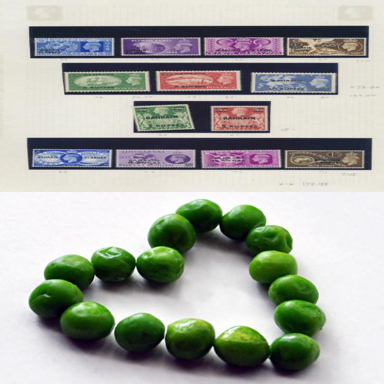

In [9]:
img = Image.open(os.path.join(img_directory, "2935.jpg")) # stamps
#img = Image.open(os.path.join(img_directory, "286.jpg")) # strawberries
img.load()
img2 = Image.open(os.path.join(img_directory, "3309.jpg")) # green peas
#img2 = Image.open(os.path.join(img_directory, "2674.jpg")) # cups
#img2 = Image.open(os.path.join(img_directory, "2203.jpg")) # apples
img2.load()

collage = create_collage(image1=img, image2=img2, type="vertical")
collage

In [10]:
#prompt = "green peas"
prompt = "stamps"
collage_array = np.array(collage)
heatmap, pred_cnt, density_map = infer(collage_array, prompt)
density_map_tensor = torch.Tensor(density_map)

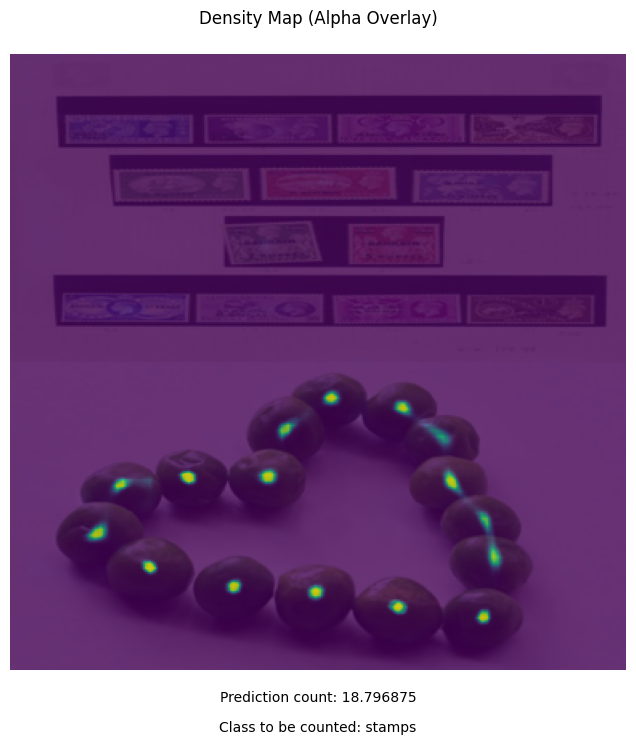

In [11]:
plt.figure(figsize=(14, 8))

# show the default heatmap of the CLIP-Count model
'''plt.imshow(heatmap, cmap='viridis')
plt.axis('off')
plt.text(0.5, 1.05, 'Image mosaic', fontsize=12, ha='center', transform=plt.gca().transAxes)'''

# show custom heatmap like already made for CounTX
plt.imshow(density_map_tensor, cmap='viridis')
plt.imshow(collage_array, cmap='viridis', alpha=0.2)
plt.text(0.5, 1.05, 'Density Map (Alpha Overlay)', fontsize=12, ha='center', transform=plt.gca().transAxes)
plt.axis('off')

plt.text(0.5, -0.05, f'Prediction count: {pred_cnt}', fontsize=10, ha='center', transform=plt.gca().transAxes)
plt.text(0.5, -0.1, f'Class to be counted: {prompt}', fontsize=10, ha='center', transform=plt.gca().transAxes)


plt.show()

In [12]:
density_map_tensor.shape[0]

384

In [13]:
upper_density = density_map_tensor[ :192, :]
lower_density = density_map_tensor[ 192:, :]
#print(upper_density.shape)

pred_cnt_up = torch.sum(upper_density / 60).item()
pred_cnt_low = torch.sum(lower_density / 60).item()

In [14]:
def show_density_maps(upper_density, lower_density, image, prompt):
    
    width, height = image.size
    half_height = height // 2
    
    top_slice = image.crop((0, 0, width, half_height))
    bottom_slice = image.crop((0, half_height, width, height))
    
    plt.figure(figsize=(14, 8))

    plt.subplot(1, 2, 1)
    plt.imshow(upper_density.numpy(), cmap='viridis')
    plt.axis('off')
    
    plt.subplot(1, 2, 1)
    plt.imshow(top_slice, cmap='viridis', alpha=0.2)
    plt.axis('off')
    
    
    plt.text(1.1, 1.05, f"Prompt: {prompt}", fontsize=12, ha='center', transform=plt.gca().transAxes)
    plt.text(0.5, 1.05, 'Top Density Map', fontsize=12, ha='center', transform=plt.gca().transAxes)
    plt.text(0.5, -0.05, f'Prediction count: {pred_cnt_up}', fontsize=10, ha='center', transform=plt.gca().transAxes)

    plt.subplot(1, 2, 2)
    plt.imshow(lower_density.numpy(), cmap='viridis')
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(bottom_slice, cmap='viridis', alpha=0.2)
    plt.axis('off')
    
    plt.text(0.5, 1.05, 'Bottom Density Map', fontsize=12, ha='center', transform=plt.gca().transAxes)
    plt.text(0.5, -0.05, f'Prediction count: {pred_cnt_low}', fontsize=10, ha='center', transform=plt.gca().transAxes)

    plt.show()

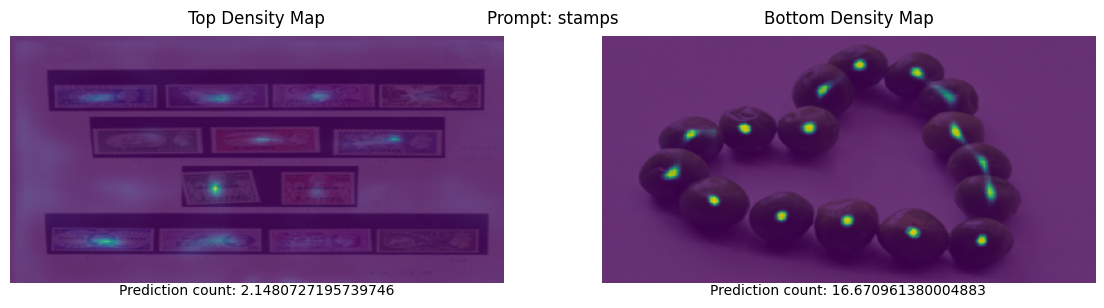

In [15]:
show_density_maps(upper_density, lower_density, collage, prompt)

### Mosaic test on all images

In [16]:
import random
import pandas as pd

In [17]:
random.seed(123)

In [18]:
def extract_random_img(class_name):
    filtered_img_classes = list({key: value for key, value in img_classes.items() if value == class_name})
    img_filename = random.choice(filtered_img_classes)
    return img_filename

In [19]:
df_upper = pd.DataFrame([], columns=split_classes["test"], index=split_images["test"])
df_lower = pd.DataFrame([], columns=split_classes["test"], index=split_images["test"])

In [20]:
random_images_list = []
for img_filename in tqdm.tqdm(split_images["test"]):
    
    img = Image.open(os.path.join(img_directory, img_filename))
    img.load()

    for class_name in split_classes["test"]:
        
        # skip couples of images with same class 
        if class_name == img_classes[img_filename]:
            continue
        
        img2_filename = extract_random_img(class_name)
        random_images_list.append(img2_filename)
        
        img2 = Image.open(os.path.join(img_directory, img2_filename))
        img2.load()
        collage = create_collage(img, img2, type="vertical")
        collage_array = np.array(collage)
        
        prompt = img_classes[img_filename]
        heatmap, pred_cnt, density_map = infer(collage_array, prompt)
        
        density_map_tensor = torch.Tensor(density_map)

        upper_density = density_map_tensor[ :192, :]
        lower_density = density_map_tensor[ 192:, :]

        pred_cnt_up = torch.sum(upper_density / 60).item()
        pred_cnt_low = torch.sum(lower_density / 60).item()

        #show_density_maps(upper_density, lower_density, collage, prompt)
        
        df_upper.at[img_filename, class_name] = pred_cnt_up 
        df_lower.at[img_filename, class_name] = pred_cnt_low
    

100%|██████████| 1190/1190 [9:08:14<00:00, 27.64s/it]  


In [21]:
random_images_list

['4.jpg',
 '4879.jpg',
 '2919.jpg',
 '7676.jpg',
 '2192.jpg',
 '911.jpg',
 '1053.jpg',
 '6711.jpg',
 '7131.jpg',
 '7192.jpg',
 '7525.jpg',
 '2029.jpg',
 '2611.jpg',
 '3112.jpg',
 '3643.jpg',
 '4118.jpg',
 '4297.jpg',
 '3496.jpg',
 '3694.jpg',
 '4061.jpg',
 '4175.jpg',
 '4493.jpg',
 '4962.jpg',
 '5919.jpg',
 '7341.jpg',
 '7123.jpg',
 '7278.jpg',
 '7440.jpg',
 '2.jpg',
 '296.jpg',
 '2919.jpg',
 '989.jpg',
 '2142.jpg',
 '905.jpg',
 '7475.jpg',
 '7707.jpg',
 '7109.jpg',
 '6960.jpg',
 '1889.jpg',
 '2039.jpg',
 '2611.jpg',
 '3114.jpg',
 '3657.jpg',
 '5380.jpg',
 '5508.jpg',
 '3496.jpg',
 '3697.jpg',
 '5597.jpg',
 '4174.jpg',
 '4492.jpg',
 '4963.jpg',
 '7173.jpg',
 '7398.jpg',
 '7523.jpg',
 '6898.jpg',
 '7486.jpg',
 '3342.jpg',
 '5821.jpg',
 '6892.jpg',
 '999.jpg',
 '2274.jpg',
 '906.jpg',
 '7500.jpg',
 '6651.jpg',
 '1463.jpg',
 '6960.jpg',
 '6980.jpg',
 '2021.jpg',
 '2615.jpg',
 '3114.jpg',
 '3657.jpg',
 '5382.jpg',
 '5458.jpg',
 '3494.jpg',
 '3698.jpg',
 '5587.jpg',
 '4175.jpg',
 '4501.jpg'

In [22]:
df_upper

,sea shells,hot air balloons,strawberries,stamps,watches,apples,comic books,sheep,markers,keyboard keys,...,candy pieces,marbles,potato chips,skis,tree logs,eggs,sauce bottles,sticky notes,nail polish,legos
2.jpg,NaN,7.503973,6.668278,7.146521,7.057618,7.263444,8.597466,7.345208,7.76123,9.46049,...,7.797405,5.335774,7.620091,5.66644,7.450207,7.489366,9.323038,8.785349,9.482021,5.735673
3.jpg,10.132363,NaN,5.996514,10.833346,12.110423,4.307755,12.955432,9.235612,7.472537,9.444844,...,6.573827,9.311712,8.610809,5.801728,6.674966,6.527614,8.784405,8.126479,6.341648,7.673394
4.jpg,5.187758,NaN,2.653245,9.610464,5.525077,2.613634,11.091774,7.93358,3.033269,8.173431,...,7.656136,5.424761,4.636849,6.202931,4.384412,11.112447,2.135479,6.457464,5.861961,4.912679
5.jpg,75.945862,NaN,65.409668,78.374947,69.181015,80.475906,79.869499,87.836639,70.34156,74.853767,...,67.216072,85.556305,55.934868,77.049576,87.439117,86.672371,60.263596,77.297523,78.047974,76.915733
6.jpg,9.380339,NaN,2.67079,10.258082,7.644049,6.482721,10.015967,10.24402,7.948324,8.852079,...,8.154539,6.698344,5.069146,4.158266,5.741346,6.482434,5.910916,8.425326,7.4121,7.08908
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6918.jpg,133.463928,116.83316,111.331924,111.64489,70.673813,115.71788,87.480919,106.147415,121.671585,106.579788,...,43.532806,113.231674,75.650505,92.318848,109.670288,133.887497,103.904892,122.437195,NaN,125.267677
7500.jpg,59.441906,110.41571,35.275063,97.214195,46.255352,1.533598,49.993713,NaN,15.925541,111.496857,...,124.73938,28.654846,17.477762,141.852036,2.71919,4.012927,3.631273,22.048183,81.562714,102.250458
7047.jpg,65.326317,54.881157,13.235445,58.352032,49.124203,2.52347,38.845173,NaN,30.746603,26.047449,...,6.76055,31.911348,43.585228,31.290819,10.347791,66.867088,9.936669,44.388611,63.661388,30.138632
7412.jpg,5.118483,7.032419,1.930919,3.530754,12.339589,7.728618,3.233438,NaN,2.511912,3.874086,...,4.527333,4.792183,10.790017,10.442128,5.460868,1.558043,3.332173,3.043722,8.822637,4.022458


In [23]:
# saving Dataframe to .csv file
df_upper.to_csv('Inference_Test2_Upper_CLIP-Count.csv')
df_lower.to_csv('Inference_Test2_Lower_CLIP-Count.csv')